## Binary Classification Example
Includes model training, threshold optimization, fairness analysis, and comparison.


==== Report ====
Bootstrap: True
Resamples: 1000

-- Classification Metrics --
auc: 0.998
auc_upper: 1.0
auc_lower: 0.991
auprc: 0.999
auprc_upper: 1.0
auprc_lower: 0.995
f1: 0.989
f1_upper: 1.0
f1_lower: 0.972
sensitivity: 0.989
sensitivity_upper: 1.0
sensitivity_lower: 0.965
specificity: 0.982
specificity_upper: 1.0
specificity_lower: 0.939
ppv: 0.989
ppv_upper: 1.0
ppv_lower: 0.965
npv: 0.982
npv_upper: 1.0
npv_lower: 0.938

-- Calibration Metrics --
brier_score: 0.018 (95% CI 0.007-0.033)

-- Regression Metrics --
Not Applicable: nan
                            


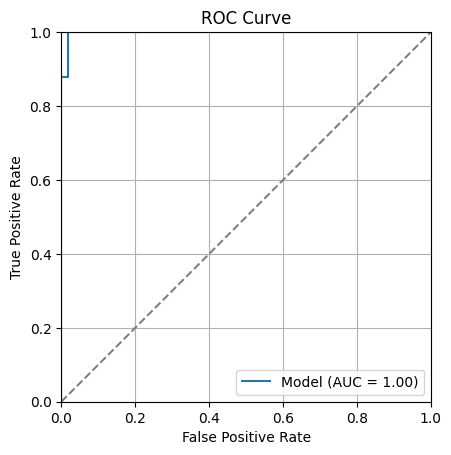

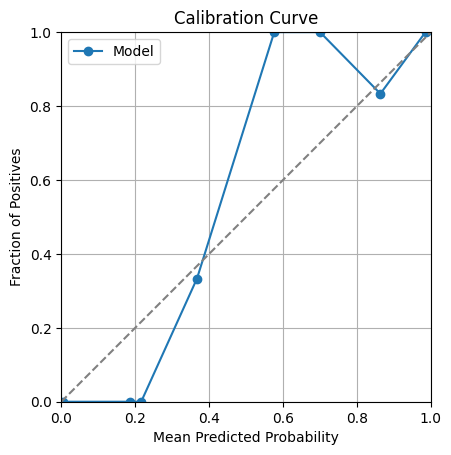

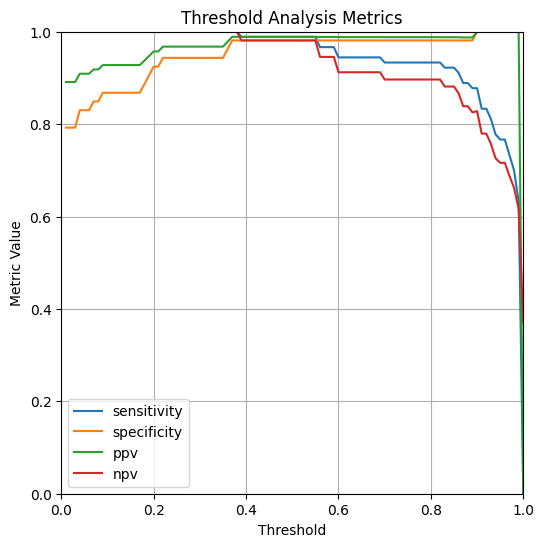

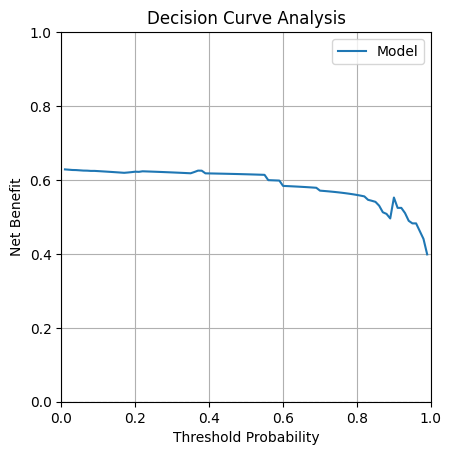

  feature   group   n       TPR  TPR_lower  TPR_upper       FPR  FPR_lower  \
0     sex    male  72  1.000000   1.000000        1.0  0.000000        0.0   
1     sex  female  71  0.977635   0.924528        1.0  0.041113        0.0   

   FPR_upper       PPV  PPV_lower  PPV_upper  
0   0.000000  1.000000   1.000000        1.0  
1   0.136364  0.979447   0.933333        1.0  
  feature   TPR_gap   PPV_gap   FPR_gap
0     sex  0.022365  0.020553  0.041113
Bootstrap AUC Comparison:
LogReg vs RF: AUC1=0.998, AUC2=0.995, p-value=0.00000
LogReg vs NB: AUC1=0.998, AUC2=0.992, p-value=0.00000
RF vs NB: AUC1=0.995, AUC2=0.992, p-value=0.00000

DeLong AUC Comparison:
LogReg vs RF: AUC1=0.998, AUC2=0.994, p-value=0.39107
LogReg vs NB: AUC1=0.998, AUC2=0.992, p-value=0.23660
RF vs NB: AUC1=0.994, AUC2=0.992, p-value=0.65837


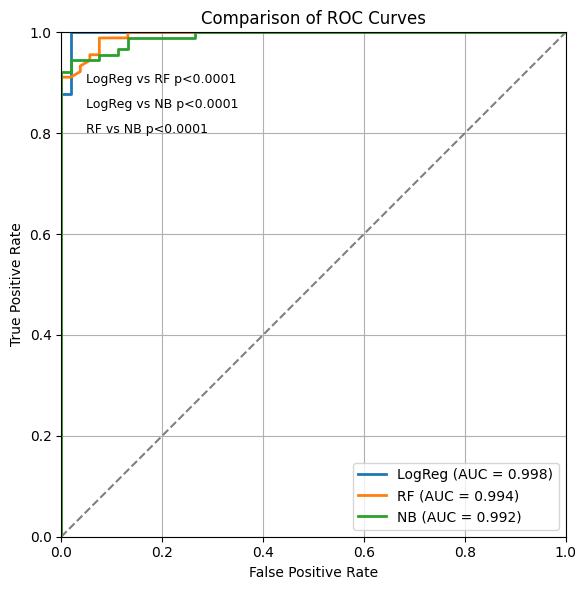

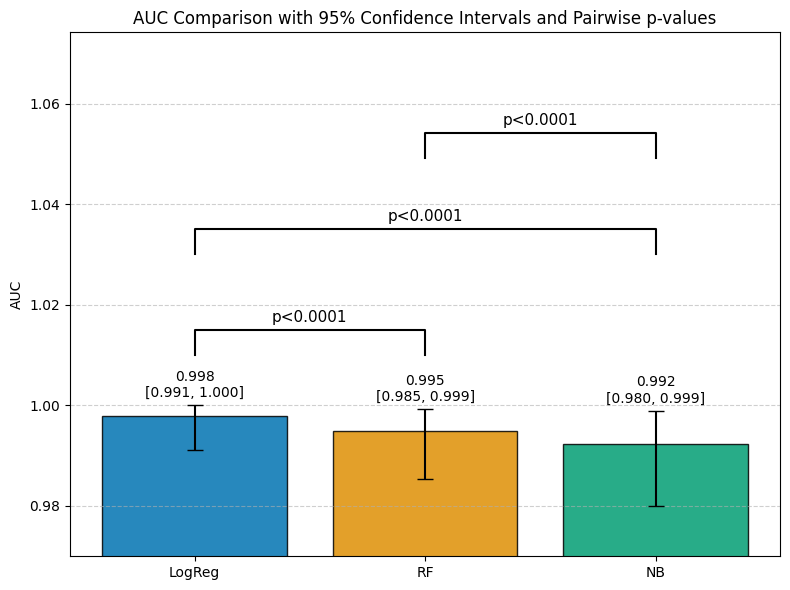

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from medevalkit.bootstrap import Bootstrapper
from medevalkit.calibration import MulticlassCalibration
from medevalkit.threshold import ThresholdOptimizer
from medevalkit.evaluate import Evaluate
from medevalkit.fairness import FairnessMetrics
from medevalkit.compare import ModelComparer
from medevalkit.plots import (
    plot_multiple_roc_curves_with_comparison, plot_auc_bar_chart_with_error_bars
)


from medevalkit.threshold import ThresholdAnalysis, DecisionCurveAnalysis
from medevalkit.plots import (
    plot_roc_curve,
    plot_calibration_curve,
    plot_threshold_metrics,
    plot_decision_curve
)

# 1. Load dataset
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2. Train models
clf = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100)
nb = BernoulliNB()

clf.fit(X_train, y_train)
rf.fit(X_train, y_train)
nb.fit(X_train, y_train)

## START HERE IF YOU HAVE A PRETRAINED MODEL ##

# 3. Threshold optimization
opt = ThresholdOptimizer(y_true=y_test, y_pred_prob=clf.predict_proba(X_test)[:, 1])
threshold = opt.optimize_youden()

# 4. Evaluate
evaluator = Evaluate(clf, X_test, y_test, classification=True, threshold=threshold)
report = evaluator.generate_report(bootstrap=True)
print(report['text_report'])

# 5. ROC and Calibration Plots
y_prob = clf.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_prob)
plot_calibration_curve(y_test, y_prob)

# 6. Threshold analysis
ta = ThresholdAnalysis(y_test, y_prob)
ta_results = ta.compute()
plot_threshold_metrics(ta_results)

# 7. Decision curve
dca = DecisionCurveAnalysis(y_test, y_prob)
dca_df = dca.compute()
plot_decision_curve(dca_df)

# 8. Fairness analysis
sex = np.array(['male' if i % 2 == 0 else 'female' for i in range(len(y_test))]) #dummy example, use real boolean indices
subgroup_indices = {
    'sex': {
        'male': np.where(sex == 'male')[0],
        'female': np.where(sex == 'female')[0]
    }
}
fair = FairnessMetrics(clf, X_test, y_test, subgroup_indices)
fair_metrics, fair_gaps = fair.compute_fairness_metrics(bootstrap=True)
print(fair_metrics)
print(fair_gaps)

# 9. Pairwise comparisons
model_dict = {"LogReg": clf, "RF": rf, "NB": nb}
comparer = ModelComparer(model_dict, X_test, y_test)

# 10. Bootstrap comparison
print("Bootstrap AUC Comparison:")
bootstrap_result = comparer.compare_auc(method='bootstrap', parametric=True, n_resamples=1000)
for k, v in bootstrap_result.items():
    print(f"{k}: AUC1={v['AUC1']:.3f}, AUC2={v['AUC2']:.3f}, p-value={v['p_value']:.5f}")

# 11. DeLong comparison
print("\nDeLong AUC Comparison:")
delong_result = comparer.compare_auc(method='delong')
for k, v in delong_result.items():
    print(f"{k}: AUC1={v['AUC1']:.3f}, AUC2={v['AUC2']:.3f}, p-value={v['p_value']:.5f}")

# 12. Plot multiple ROC curves
model_probs = {
    "LogReg": clf.predict_proba(X_test)[:, 1],
    "RF": rf.predict_proba(X_test)[:, 1],
    "NB": nb.predict_proba(X_test)[:, 1],
}
plot_multiple_roc_curves_with_comparison(
    y_true=y_test,
    model_probs=model_probs,
    method="bootstrap",
    show_pvalues_on_plot=True
)

# 13. Extract p-values for plotting
pval_df = pd.DataFrame([
    {
        "Model 1": m1,
        "Model 2": m2,
        "p-value": v["p_value"]
    }
    for k, v in bootstrap_result.items()
    for m1, m2 in [k.split(" vs ")]
])

# 14. Plot pairwise comparison bar chart
bs = Bootstrapper(n_resamples=1000)
auc_dict = {
    "LogReg": bs.bootstrap(metric_fn=roc_auc_score, y_true=y_test, y_pred=clf.predict_proba(X_test)[:, 1]),
    "RF": bs.bootstrap(metric_fn=roc_auc_score, y_true=y_test, y_pred=rf.predict_proba(X_test)[:, 1]),
    "NB": bs.bootstrap(metric_fn=roc_auc_score, y_true=y_test, y_pred=nb.predict_proba(X_test)[:, 1]),
}
plot_auc_bar_chart_with_error_bars(
    auc_dict=auc_dict,
    pval_df=pval_df,
    title="AUC Comparison with 95% Confidence Intervals and Pairwise p-values"
)

## Binary Classification with Simulated Incidence Rates

In [ ]:
from medevalkit.evaluate import EvaluateWithSimulation

#Evaluate with Simulation
sim = EvaluateWithSimulation(clf, X_test, y_test, classification=True)
sim.run_simulation(bootstrap = True, n_resamples = 100)
sim_metrics_df = sim.generate_metrics()
print("Metrics at various simulated incidence rates:")
display(sim_metrics_df)

Metrics at various simulated incidence rates:


,0.01,0.05,0.10,0.20,0.30,0.40,0.50,0.60,0.63,0.70,0.80,0.90,0.95,0.99
auc,0.998 (95% CI 0.998-0.998),0.997 (95% CI 0.997-0.997),0.998 (95% CI 0.998-0.998),0.998 (95% CI 0.998-0.998),0.998 (95% CI 0.998-0.998),0.997 (95% CI 0.997-0.997),0.998 (95% CI 0.998-0.998),0.998 (95% CI 0.998-0.998),0.997 (95% CI 0.997-0.997),0.998 (95% CI 0.998-0.998),0.998 (95% CI 0.998-0.998),0.999 (95% CI 0.999-0.999),0.997 (95% CI 0.997-0.997),0.996 (95% CI 0.996-0.996)
auprc,0.929 (95% CI 0.929-0.929),0.965 (95% CI 0.965-0.965),0.982 (95% CI 0.982-0.982),0.991 (95% CI 0.991-0.991),0.995 (95% CI 0.995-0.995),0.996 (95% CI 0.996-0.996),0.998 (95% CI 0.998-0.998),0.999 (95% CI 0.999-0.999),0.998 (95% CI 0.998-0.998),0.999 (95% CI 0.999-0.999),0.999 (95% CI 0.999-0.999),1.000 (95% CI 1.000-1.000),1.000 (95% CI 1.000-1.000),1.000 (95% CI 1.000-1.000)
f1,0.593 (95% CI 0.593-0.593),0.840 (95% CI 0.840-0.840),0.926 (95% CI 0.926-0.926),0.956 (95% CI 0.956-0.956),0.972 (95% CI 0.972-0.972),0.980 (95% CI 0.980-0.980),0.986 (95% CI 0.986-0.986),0.988 (95% CI 0.988-0.988),0.988 (95% CI 0.988-0.988),0.991 (95% CI 0.991-0.991),0.993 (95% CI 0.993-0.993),0.994 (95% CI 0.994-0.994),0.994 (95% CI 0.994-0.994),0.994 (95% CI 0.994-0.994)
sensitivity,0.995 (95% CI 0.995-0.995),0.988 (95% CI 0.988-0.988),0.992 (95% CI 0.992-0.992),0.987 (95% CI 0.987-0.987),0.988 (95% CI 0.988-0.988),0.988 (95% CI 0.988-0.988),0.990 (95% CI 0.990-0.990),0.988 (95% CI 0.988-0.988),0.989 (95% CI 0.989-0.989),0.989 (95% CI 0.989-0.989),0.990 (95% CI 0.990-0.990),0.988 (95% CI 0.988-0.988),0.990 (95% CI 0.990-0.990),0.988 (95% CI 0.988-0.988)
specificity,0.982 (95% CI 0.982-0.982),0.979 (95% CI 0.979-0.979),0.983 (95% CI 0.983-0.983),0.980 (95% CI 0.980-0.980),0.981 (95% CI 0.981-0.981),0.981 (95% CI 0.981-0.981),0.982 (95% CI 0.982-0.982),0.981 (95% CI 0.981-0.981),0.980 (95% CI 0.980-0.980),0.982 (95% CI 0.982-0.982),0.982 (95% CI 0.982-0.982),0.994 (95% CI 0.994-0.994),0.977 (95% CI 0.977-0.977),0.968 (95% CI 0.968-0.968)
ppv,0.421 (95% CI 0.421-0.421),0.731 (95% CI 0.731-0.731),0.870 (95% CI 0.870-0.870),0.927 (95% CI 0.927-0.927),0.956 (95% CI 0.956-0.956),0.971 (95% CI 0.971-0.971),0.982 (95% CI 0.982-0.982),0.987 (95% CI 0.987-0.987),0.987 (95% CI 0.987-0.987),0.992 (95% CI 0.992-0.992),0.996 (95% CI 0.996-0.996),0.999 (95% CI 0.999-0.999),0.999 (95% CI 0.999-0.999),1.000 (95% CI 1.000-1.000)
npv,1.000 (95% CI 1.000-1.000),0.999 (95% CI 0.999-0.999),0.999 (95% CI 0.999-0.999),0.997 (95% CI 0.997-0.997),0.995 (95% CI 0.995-0.995),0.992 (95% CI 0.992-0.992),0.990 (95% CI 0.990-0.990),0.982 (95% CI 0.982-0.982),0.982 (95% CI 0.982-0.982),0.976 (95% CI 0.976-0.976),0.960 (95% CI 0.960-0.960),0.908 (95% CI 0.908-0.908),0.844 (95% CI 0.844-0.844),0.475 (95% CI 0.475-0.475)
brier_score,0.023 (95% CI 0.023-0.023),0.024 (95% CI 0.024-0.024),0.021 (95% CI 0.021-0.021),0.022 (95% CI 0.022-0.022),0.021 (95% CI 0.021-0.021),0.021 (95% CI 0.021-0.021),0.019 (95% CI 0.019-0.019),0.019 (95% CI 0.019-0.019),0.018 (95% CI 0.018-0.018),0.017 (95% CI 0.017-0.017),0.016 (95% CI 0.016-0.016),0.015 (95% CI 0.015-0.015),0.016 (95% CI 0.016-0.016),0.015 (95% CI 0.015-0.015)


## Multiclass Classification Example
Includes model training, per-class thresholding, ROC-AUC comparison, and fairness.

Thresholds: {np.int64(0): np.float64(0.7288107609943075), np.int64(1): np.float64(0.6299389785296711), np.int64(2): np.float64(0.4294279597363074)}
Predictions: [0 0 1 2 0 2 1 1 0 1]


/Users/Wesley/data/nuhs/evalkit/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



==== Report ====
Bootstrap: True
Resamples: 1000

-- Classification Metrics --
auc (macro): 0.967
precision (macro): 0.921
recall (macro): 0.923
auc (macro)_upper: 1.0
auc (macro)_lower: 0.914
f1 (macro): 0.916
f1 (macro)_upper: 1.0
f1 (macro)_lower: 0.816
precision (macro)_upper: 1.0
precision (macro)_lower: 0.816
recall (macro)_upper: 1.0
recall (macro)_lower: 0.823

-- Calibration Metrics --
0_brier_score: 0.01 (95% CI 0.005-0.016)
1_brier_score: 0.1 (95% CI 0.067-0.138)
2_brier_score: 0.082 (95% CI 0.052-0.117)

-- Regression Metrics --
Not Applicable: nan
                            


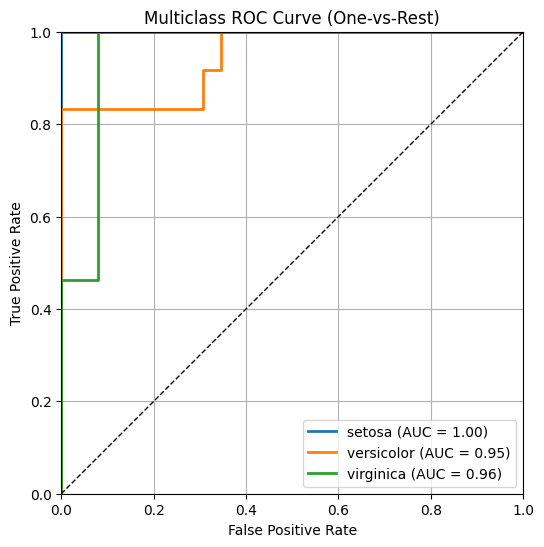

Expected Calibration Error (ECE): {'expected_calibration_error': np.float64(0.17840573775902888), 'expected_calibration_error_upper': np.float64(0.2414867225463526), 'expected_calibration_error_lower': np.float64(0.12137351908994028)}


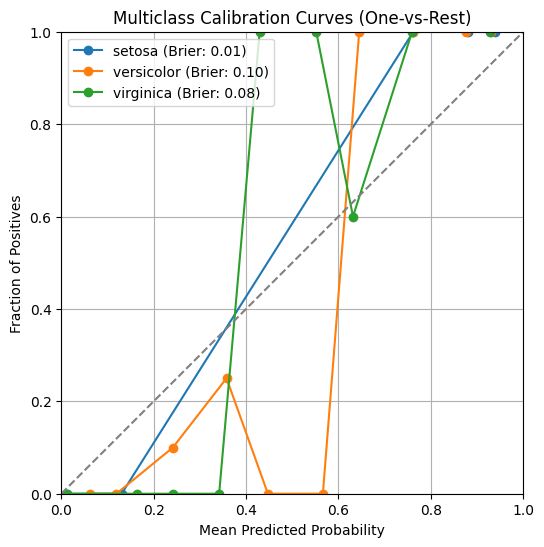

/Users/Wesley/data/nuhs/evalkit/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Wesley/data/nuhs/evalkit/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Wesley/data/nuhs/evalkit/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Multiclass metrics by subgroup:
   feature    group   n       TPR  TPR_lower  TPR_upper       PPV  PPV_lower  \
0   group  group 1  19  0.828219   0.666667        1.0  0.862060   0.518519   
1   group  group 2  19  0.957943   0.866667        1.0  0.963378   0.875000   

   PPV_upper  FPR  
0        1.0  NaN  
1        1.0  NaN  

Fairness gaps:
   feature   TPR_gap   PPV_gap  FPR_gap
0   group  0.129725  0.101318      NaN


In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from medevalkit.threshold import MulticlassThresholdOptimizer
from medevalkit.evaluate import Evaluate
from medevalkit.compare import ModelComparer
from medevalkit._plots import (
    plot_multiclass_roc, plot_multiclass_calibration
)

# 1. Load dataset
iris = load_iris()
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2. Train models
clf = LogisticRegression(multi_class='ovr', max_iter=1000)
rf = RandomForestClassifier()
nb = BernoulliNB()

clf.fit(X_train, y_train)
rf.fit(X_train, y_train)
nb.fit(X_train, y_train)

## START HERE IF YOU HAVE A PRETRAINED MODEL ##

# 3. Threshold optimization
clf_probs = clf.predict_proba(X_test)
mopt = MulticlassThresholdOptimizer(y_test, clf_probs)
thresholds = mopt.optimize_per_class(method='f1')
y_pred_thresh = mopt.predict()
print('Thresholds:', thresholds)
print('Predictions:', y_pred_thresh[:10])

# 4. Evaluate
eval_multi = Evaluate(clf, X_test, y_test, classification=True)
report_multi = eval_multi.generate_report(bootstrap=True)
print(report_multi['text_report'])

# 5. Multiclass ROC
plot_multiclass_roc(y_test, clf.predict_proba(X_test), class_labels=iris.target_names)

# 6. Multiclass calibration
cal = MulticlassCalibration(y_test, clf.predict_proba(X_test))
print("Expected Calibration Error (ECE):", cal.expected_calibration_error())
plot_multiclass_calibration(cal, class_labels=iris.target_names)

# 7. Fairness analysis
group = np.array(['group 1' if i % 2 == 0 else 'group 2' for i in range(len(y_test))]) #dummy example, use real boolean indices
subgroup_indices = {
    'group': {
        'group 1': np.where(group == 'group 1')[0],
        'group 2': np.where(group == 'group 2')[0]
    }
}
fair = FairnessMetrics(clf, X_test, y_test, subgroup_indices, average="macro")
metrics_df, gap_df = fair.compute_fairness_metrics(bootstrap=True, n_resamples=300)

print("Multiclass metrics by subgroup:\n", metrics_df)
print("\nFairness gaps:\n", gap_df)

# 6. Comparison for multiclass models are not yet implemented

## Regression Example
Basic regression evaluation using medevalkit.

In [ ]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from medevalkit.evaluate import Evaluate

X, y = make_regression(n_samples=300, n_features=10, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

evaluator = Evaluate(model=regressor, x=X_test, y=y_test, classification=False)
report = evaluator.generate_report()
print(report['text_report'])



==== Report ====
Bootstrap: True
Resamples: 1000

-- Classification Metrics --
Not Applicable: nan

-- Calibration Metrics --
Not Applicable: nan

-- Regression Metrics --
mse: 0.011 (95% CI 0.008-0.016)
mae: 0.086 (95% CI 0.073-0.1)
                            


## Time-to-Event (Survival) Analysis
This example uses a synthetic dataset to simulate time-to-event analysis. We show how to evaluate time-dependent performance of a risk score.

## Binary Classifier Survival Evaluation with Landmarking
This example evaluates a binary classifier using time-dependent AUC and Kaplan-Meier curves.

Dynamic AUC at specified time points:
    time      mean     lower     upper
0     2  0.693941  0.576921  0.799620
1     4  0.739035  0.655222  0.816347
2     6  0.762691  0.675260  0.847536
3     8  0.758521  0.670170  0.842962
4    10  0.769298  0.681310  0.852266
5    12  0.793520  0.704586  0.874874
6    14  0.775199  0.678543  0.869609


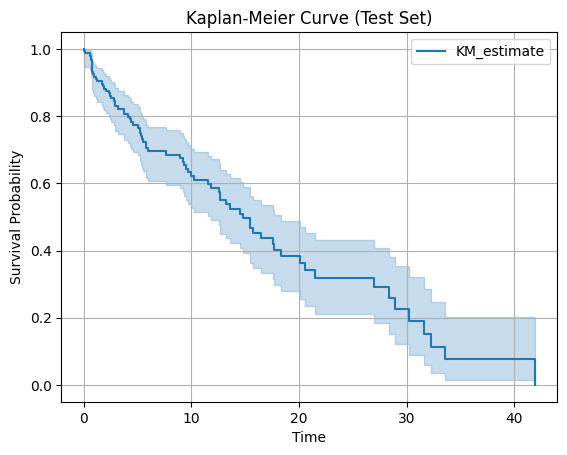

--- Evaluation for prediction window: 4 ---
   time      mean     lower     upper
0     2  0.693941  0.576921  0.799620
1     4  0.739035  0.655222  0.816347
2     6  0.762691  0.675260  0.847536
3     8  0.758521  0.670170  0.842962
4    10  0.769298  0.681310  0.852266
5    12  0.793520  0.704586  0.874874
6    14  0.775199  0.678543  0.869609 

--- Evaluation for prediction window: 8 ---
   time      mean     lower     upper
0     2  0.693941  0.576921  0.799620
1     4  0.739035  0.655222  0.816347
2     6  0.762691  0.675260  0.847536
3     8  0.758521  0.670170  0.842962
4    10  0.769298  0.681310  0.852266
5    12  0.793520  0.704586  0.874874
6    14  0.775199  0.678543  0.869609 

--- Evaluation for prediction window: 12 ---
   time      mean     lower     upper
0     2  0.693941  0.576921  0.799620
1     4  0.739035  0.655222  0.816347
2     6  0.762691  0.675260  0.847536
3     8  0.758521  0.670170  0.842962
4    10  0.769298  0.681310  0.852266
5    12  0.793520  0.704586

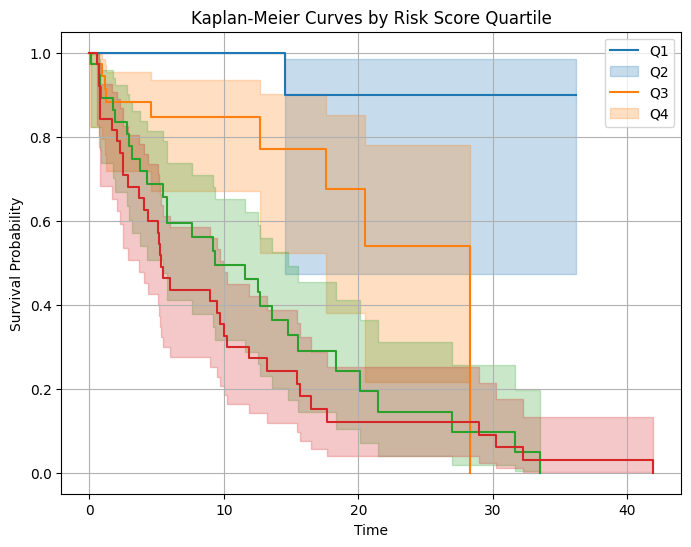

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from medevalkit.survival import LandmarkSurvivalEvaluator
from medevalkit._plots import plot_kaplan_meier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulate dataset with synthetic survival information
np.random.seed(42)
X, y_bin = make_classification(n_samples=500, n_features=5)
durations = np.random.exponential(scale=10, size=500)
events = y_bin  # Use binary labels as event indicators (for demo purposes)

# Train/test split
X_train, X_test, d_train, d_test, e_train, e_test = train_test_split(
    X, durations, events, test_size=0.3, stratify=events, random_state=42
)

# Train classifier to predict events within 8 days
label_train = ((d_train <= 8) & (e_train == 1)).astype(int)
clf = LogisticRegression().fit(X_train, label_train)

# Initialize evaluator with model and landmark window
evaluator = LandmarkSurvivalEvaluator(model=clf, prediction_window=8)
evaluator.fit(X_train, d_train, e_train)  # Store training survival data for AUC

# Dynamic AUC at specific time points
time_points = [2, 4, 6, 8, 10, 12, 14]
summary_df = evaluator.evaluate_dynamic_auc(X_test, d_test, e_test, times=time_points, n_resamples=200)
print("Dynamic AUC at specified time points:\n", summary_df)

# Plot Kaplan-Meier for full test set
plot_kaplan_meier(durations=d_test, events=e_test)
plt.title("Kaplan-Meier Curve (Test Set)")
plt.show()

# Multiple prediction windows
windows = [4, 8, 12]
for window in windows:
    print(f"--- Evaluation for prediction window: {window} ---")
    evaluator.prediction_window = window
    summary_df = evaluator.evaluate_dynamic_auc(X_test, d_test, e_test, times=time_points, n_resamples=200)
    print(summary_df, "\n")

# Calibration plot by risk score quartiles
y_prob = clf.predict_proba(X_test)[:, 1]
df_risk = pd.DataFrame({
    'risk_score': y_prob,
    'duration': d_test,
    'event': e_test
})
df_risk['quartile'] = pd.qcut(df_risk['risk_score'], 4, labels=False)

# Plot survival by quartile
plt.figure(figsize=(8, 6))
for q in range(4):
    mask = df_risk['quartile'] == q
    plot_kaplan_meier(df_risk.loc[mask, 'duration'], df_risk.loc[mask, 'event'])
plt.title("Kaplan-Meier Curves by Risk Score Quartile")
plt.legend([f"Q{q+1}" for q in range(4)])
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()